In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.core.display import display, HTML
import pandas as pd
import seaborn as sns

from keras.models import Model, load_model

from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, confusion_matrix, classification_report, balanced_accuracy_score, f1_score

from sys import path
path.append(".."); from generate_patients import Patient

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
display(HTML("<style>.container { width:90% !important; }</style>"))
plt.interactive(True)
%matplotlib inline
plt.rcParams['figure.figsize'] = [26, 6]

In [3]:
with open('../spectrograms_tugs.pkl', 'rb') as specgram_file:
    patients = pickle.load(specgram_file)

data = [patient['specgram'] for patient in patients]
labels = [patient['label'] for patient in patients]

print('Number of spectrograms: %s' % len(data))

Number of spectrograms: 72


In [4]:
data_train, data_test, y_train, y_test = train_test_split(data, labels, test_size = 0.25, stratify=labels)
print('Training set:', len(data_train), '\tTest set:', len(data_test))

Training set: 54 	Test set: 18


In [5]:
specgrams_train, specgrams_test = [], data_test
for specgram in data_train:
    specgrams_train.append(specgram)
    specgrams_train.append(np.flip(specgram, 0))       # flip rows / y axis
    specgrams_train.append(np.flip(specgram, 1))       # flip columns / x axis
    specgrams_train.append(np.flip(specgram, (0, 1)))  # flip rows and columns / x and y axis

y_train = [label for label in y_train for _ in range(4)]
print('Training set:', len(specgrams_train), '\tTest set:', len(specgrams_test))

Training set: 216 	Test set: 18


## Load 500 features autoencoder model and extract encoder layers

In [6]:
autoencoder = load_model('../Autoencoders/best_model_TUGs_500.h5')

encoder = Model(autoencoder.layers[0].input, autoencoder.layers[8].output)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 200, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 200, 32)       832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 200, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 100, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 100, 8)        6408      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 100, 8)        32        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 50, 8)          0         
__________

### Extract features from spectrograms and normalize

In [7]:
scaler = StandardScaler()

reshape = np.reshape(specgrams_train, (len(specgrams_train), specgrams_train[0].shape[0], specgrams_train[0].shape[1], 1))
features_train = encoder.predict([reshape])
features_norm_train = scaler.fit_transform(features_train)
print('Before Scaling:\t Max: %s\tMin: %s\nAfter Scaling:\t Max: %s\tMin: %s' % (np.min(features_train), np.max(features_train), np.min(features_norm_train), np.max(features_norm_train)))

Before Scaling:	 Max: 0.0	Min: 10.384619
After Scaling:	 Max: -5.0451946	Min: 14.513955


In [8]:
reshape = np.reshape(specgrams_test, (len(specgrams_test), specgrams_test[0].shape[0], specgrams_test[0].shape[1], 1))
features_test = encoder.predict([reshape])
features_norm_test = scaler.transform(features_test)
print('Before Scaling:\t Max: %s\tMin: %s\nAfter Scaling:\t Max: %s\tMin: %s' % (np.min(features_test), np.max(features_test), np.min(features_norm_test), np.max(features_norm_test)))

Before Scaling:	 Max: 0.0	Min: 10.236153
After Scaling:	 Max: -3.5360084	Min: 12.416857


### Analyze PCA cumulative variance

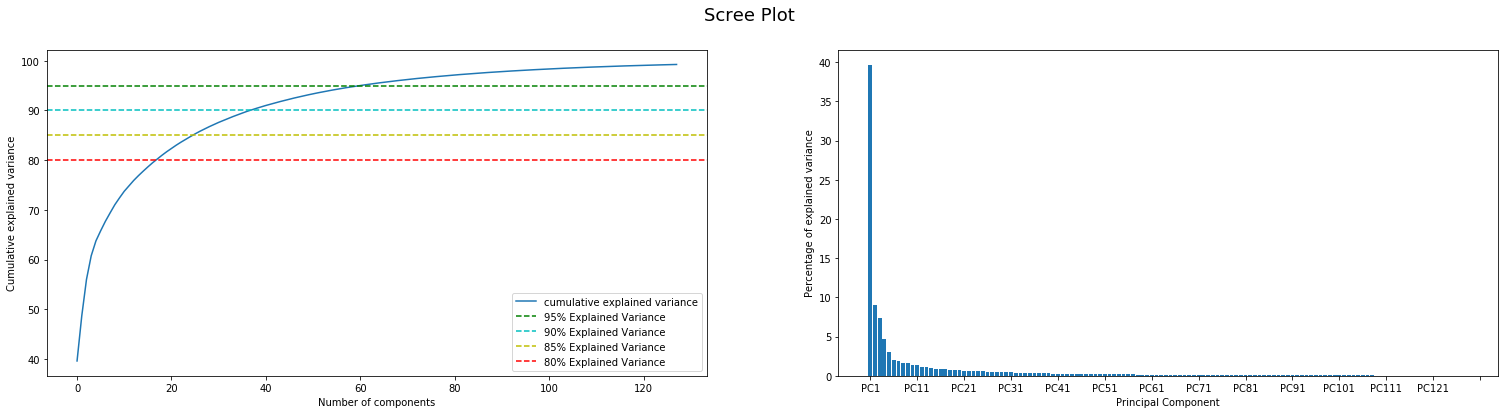

In [9]:
pca = PCA(n_components=128)
pca.fit(features_norm_train)
explained_variance = pca.explained_variance_ratio_*100

plt.subplot(121)
plt.plot(np.cumsum(explained_variance), label='cumulative explained variance')
plt.axhline(y = 95, color='g', linestyle='--', label = '95% Explained Variance')
plt.axhline(y = 90, color='c', linestyle='--', label = '90% Explained Variance')
plt.axhline(y = 85, color='y', linestyle='--', label = '85% Explained Variance')
plt.axhline(y = 80, color='r', linestyle='--', label = '80% Explained Variance')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.legend(loc='best')

plt.subplot(122).get_xaxis().set_major_locator(plt.MaxNLocator(16))
plt.bar(['PC%s' % i for i in range(1, len(explained_variance)+1)], explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Percentage of explained variance')

plt.suptitle('Scree Plot', fontsize=18)
plt.show()

### Define Classifier Objects, Parameter Grid Variables and Number of PCA Components

In [10]:
rf_classifier = (RandomForestClassifier(class_weight='balanced') for i in iter(int, 1))
rf_parameter_grid = {'n_estimators':[50, 100, 200, 400], 'max_depth':[20, 40, 80, 120], 'max_features':['sqrt', 'log2']}

svc_classifier = (SVC(probability=True, class_weight='balanced') for i in iter(int, 1))
svc_parameter_grid = [{'kernel': ['rbf'],  'gamma': [1e-5, 1e-4, 0.0005, 1e-3, 0.005, 1e-2], 'C': [0.1, 1, 5, 10, 50, 100]},
                      {'kernel': ['poly'], 'gamma': [1e-5, 1e-4, 0.0005, 1e-3, 0.005, 1e-2], 'C': [0.1, 1, 5, 10, 50, 100], 'degree': [2, 3]}]

gb_classifier = (GradientBoostingClassifier() for i in iter(int, 1))
gb_parameter_grid = {'n_estimators': [40, 60, 80], 'max_depth': [4, 8, 12, 16, 20], 'max_features':['log2', 'sqrt'], 'learning_rate': [0.05, 0.1, 0.2]}

adab_classifier = (AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced')) for i in iter(int, 1))
adab_parameter_grid = {'n_estimators': [50, 100, 200], 'learning_rate' : [0.1, 0.5, 1], 'base_estimator__max_depth': [1, 2, 4]}

pca_components = [64, 32, 16]
classifiers = [(rf_classifier, rf_parameter_grid, 'RandomForest'), (svc_classifier, svc_parameter_grid, 'SVM'),
               (gb_classifier, gb_parameter_grid, 'GradientBoosting'), (adab_classifier, adab_parameter_grid, 'AdaBoosting')]

### Start training classifiers using 4-fold cross validation and prioritizing ROC AUC score

In [11]:
def train_predict(X_train, X_test, classifier, parameters):
    grid_search = GridSearchCV(next(classifier), param_grid=parameters, cv=StratifiedKFold(n_splits=4), scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print('Best parameters: %s' % grid_search.best_params_)
    print('Best mean score: %s' % grid_search.best_score_)
    print('Standard Deviation: %s\n' % grid_search.cv_results_['std_test_score'][np.argmin(grid_search.cv_results_['rank_test_score'])])

    SVC_classifier = grid_search.best_estimator_
    return SVC_classifier.predict_proba(X_test)[:, 1]

In [12]:
results = {}
for classifier, parameters, classifier_name in classifiers:
    if classifier_name == 'RandomForest':
        print('%s' % classifier_name)

        X_train = features_train
        X_test = features_test
        
        results['%s' % classifier_name] = train_predict(X_train, X_test, classifier, parameters)
        continue

    for n_components in pca_components:
        print('%s_%s' % (classifier_name, n_components))
        
        pca = PCA(n_components=n_components)
        X_train = pca.fit_transform(features_norm_train)
        X_test = pca.transform(features_norm_test)
        print('PCA Explained Variance:', sum(pca.explained_variance_ratio_))
        
        results['%s_%s' % (classifier_name, n_components)] = train_predict(X_train, X_test, classifier, parameters)

RandomForest
Best parameters: {'max_depth': 120, 'max_features': 'sqrt', 'n_estimators': 50}
Best mean score: 0.6620535714285715
Standard Deviation: 0.05095351961066368

SVM_64
PCA Explained Variance: 0.9542791355634108
Best parameters: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Best mean score: 0.5308035714285714
Standard Deviation: 0.05485624476106358

SVM_32
PCA Explained Variance: 0.8799682217650115
Best parameters: {'C': 0.1, 'degree': 2, 'gamma': 1e-05, 'kernel': 'poly'}
Best mean score: 0.5191964285714286
Standard Deviation: 0.07540679432320431

SVM_16
PCA Explained Variance: 0.78652080334723
Best parameters: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Best mean score: 0.5924107142857143
Standard Deviation: 0.07251819572862178

GradientBoosting_64
PCA Explained Variance: 0.9542791355634108
Best parameters: {'learning_rate': 0.1, 'max_depth': 16, 'max_features': 'log2', 'n_estimators': 60}
Best mean score: 0.4691964285714285
Standard Deviation: 0.10569237677170983

GradientBoo

## Results

In [13]:
df_results = pd.read_pickle("../results.pkl")  # Load pandas dataframe containing results summary

In [14]:
def collect_and_print_results(y_prob):   
    auc_score = roc_auc_score(y_test, y_prob)
    if auc_score < 0.5:
        auc_score, y_prob = (1 - auc_score, 1 - y_prob)
    
    fpr, tpr, thresholds1 = roc_curve(y_test, y_prob, drop_intermediate=False)
    precision, recall, thresholds2 = precision_recall_curve(y_test, y_prob)
    
    optimal_idx1 = np.argmax(tpr - fpr)
    optimal_threshold = thresholds1[optimal_idx1]
    optimal_idx2 = np.argmin(np.abs(thresholds2 - optimal_threshold))
    y_pred = np.array([1 if y >= optimal_threshold else 0 for y in y_prob])

    average_precision = average_precision_score(y_test, y_prob)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)  # Average of Recall
    F1_score = f1_score(y_test, y_pred)

    plt.subplot(131)
    plt.title('Confusion Matrix (F1 Score: %0.2f ,BA: %0.2f)' % (F1_score, balanced_accuracy))
    sns.heatmap(confusion_matrix(y_test, y_pred), vmin=0, cmap='RdYlGn', annot=True, annot_kws={"size": 14})

    plt.subplot(132)
    plt.plot(fpr, tpr, color='b', label='ROC Curve', lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.5)
    plt.plot(fpr[optimal_idx1], tpr[optimal_idx1], marker='X', color='red',markersize=14)
    
    plt.title('ROC curve (AUC: %0.2f)' % auc_score)
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.grid(True, alpha=0.5)

    plt.subplot(133)
    plt.plot(recall, precision, color='green', label='Precision-Recall Curve', lw=2, alpha=.8)
    plt.fill_between(recall, precision, alpha=0.2, color='g', step='post')
    plt.plot(recall[optimal_idx2], precision[optimal_idx2], marker='X', color='red',markersize=14)

    plt.title('Precision-Recall Curve (AP: %0.2f)' % average_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower left")
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.grid(True, alpha=0.5)

    print(classification_report(y_test, y_pred, target_names=['Non Fallers', 'Fallers']))
    print('ROC Area Under Curve:', round(auc_score, 2))
    print('Average Precision:   ', round(average_precision, 2))
    print('Balanced Accuracy:   ', round(balanced_accuracy, 2))
    print('F1 Score:            ', round(F1_score, 2))
    
    return auc_score, average_precision, balanced_accuracy, F1_score

### Random Forest Classifier without PCA

              precision    recall  f1-score   support

 Non Fallers       1.00      0.38      0.56        13
     Fallers       0.38      1.00      0.56         5

   micro avg       0.56      0.56      0.56        18
   macro avg       0.69      0.69      0.56        18
weighted avg       0.83      0.56      0.56        18

ROC Area Under Curve: 0.54
Average Precision:    0.32
Balanced Accuracy:    0.69
F1 Score:             0.56
---  Results saved!  ---


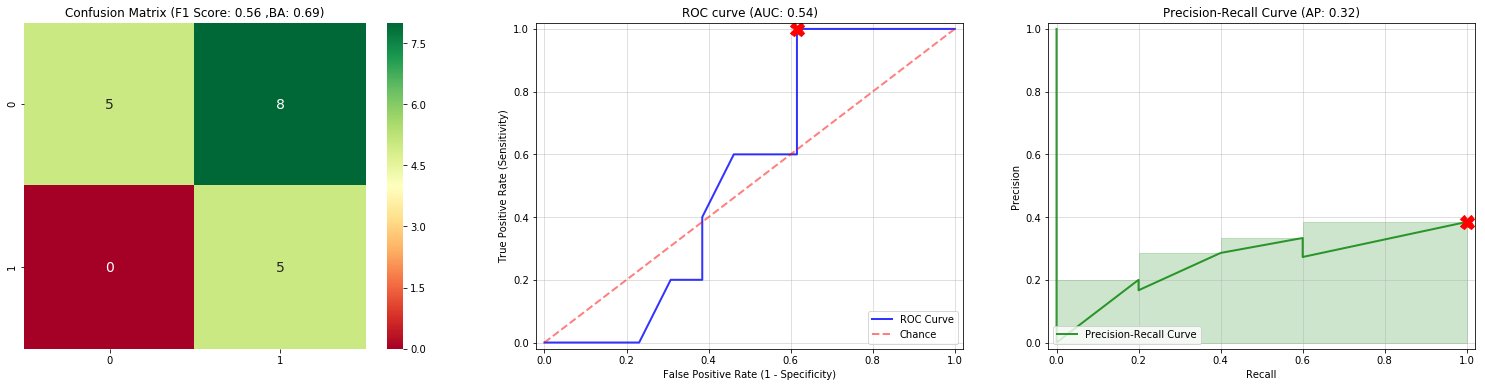

In [15]:
auc_score, average_precision, balanced_accuracy, F1_score = collect_and_print_results(results['RandomForest'])

index_name = 'RandomForest_TUGs_500'
if index_name not in df_results.index or (auc_score + F1_score)/2 > (df_results.loc[index_name, 'AUC_Score'] + df_results.loc[index_name, 'F1_Score'])/2:
    df_results.loc[index_name, :] = ['TUGs', 'RandomForest', '500', 'None', auc_score, F1_score, average_precision, balanced_accuracy]
    plt.savefig(index_name + '.png', bbox_inches='tight')
    df_results.to_pickle("../results.pkl")
    print('---  Results saved!  ---')

### SVM Classifier on 64 Components PCA

              precision    recall  f1-score   support

 Non Fallers       1.00      0.46      0.63        13
     Fallers       0.42      1.00      0.59         5

   micro avg       0.61      0.61      0.61        18
   macro avg       0.71      0.73      0.61        18
weighted avg       0.84      0.61      0.62        18

ROC Area Under Curve: 0.68
Average Precision:    0.53
Balanced Accuracy:    0.73
F1 Score:             0.59
---  Results saved!  ---


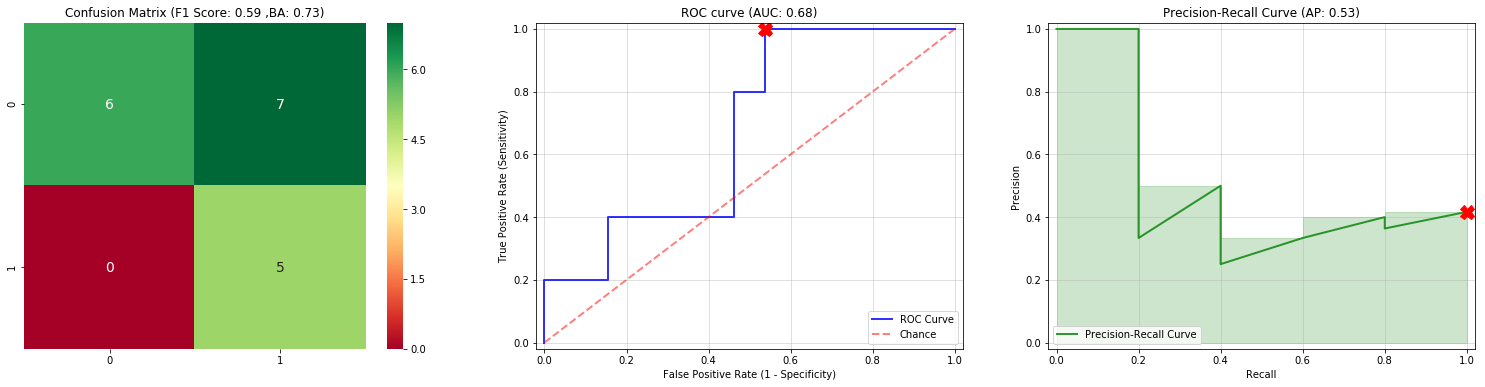

In [16]:
auc_score, average_precision, balanced_accuracy, F1_score = collect_and_print_results(results['SVM_64'])

index_name = 'SVM_TUGs_500_64'
if index_name not in df_results.index or (auc_score + F1_score)/2 > (df_results.loc[index_name, 'AUC_Score'] + df_results.loc[index_name, 'F1_Score'])/2:
    df_results.loc[index_name, :] = ['TUGs', 'SVM', '500', '64', auc_score, F1_score, average_precision, balanced_accuracy]
    plt.savefig(index_name + '.png', bbox_inches='tight')
    df_results.to_pickle("../results.pkl")
    print('---  Results saved!  ---')

### SVM Classifier on 32 Components PCA

              precision    recall  f1-score   support

 Non Fallers       1.00      0.85      0.92        13
     Fallers       0.71      1.00      0.83         5

   micro avg       0.89      0.89      0.89        18
   macro avg       0.86      0.92      0.88        18
weighted avg       0.92      0.89      0.89        18

ROC Area Under Curve: 0.86
Average Precision:    0.6
Balanced Accuracy:    0.92
F1 Score:             0.83
---  Results saved!  ---


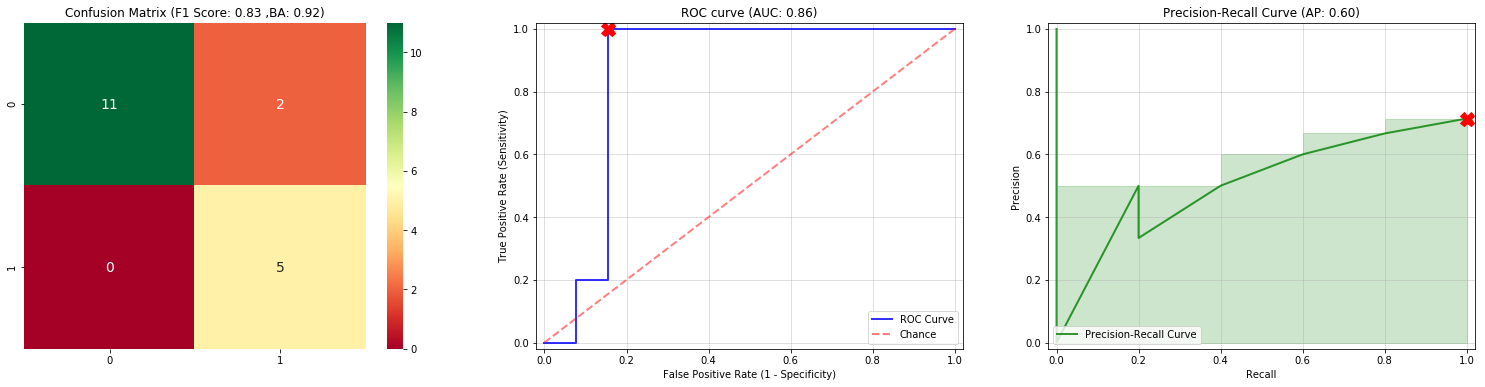

In [17]:
auc_score, average_precision, balanced_accuracy, F1_score = collect_and_print_results(results['SVM_32'])

index_name = 'SVM_TUGs_500_32'
if index_name not in df_results.index or (auc_score + F1_score)/2 > (df_results.loc[index_name, 'AUC_Score'] + df_results.loc[index_name, 'F1_Score'])/2:
    df_results.loc[index_name, :] = ['TUGs', 'SVM', '500', '32', auc_score, F1_score, average_precision, balanced_accuracy]
    plt.savefig(index_name + '.png', bbox_inches='tight')
    df_results.to_pickle("../results.pkl")
    print('---  Results saved!  ---')

### SVM Classifier on 16 Components PCA

              precision    recall  f1-score   support

 Non Fallers       0.82      0.69      0.75        13
     Fallers       0.43      0.60      0.50         5

   micro avg       0.67      0.67      0.67        18
   macro avg       0.62      0.65      0.62        18
weighted avg       0.71      0.67      0.68        18

ROC Area Under Curve: 0.58
Average Precision:    0.39
Balanced Accuracy:    0.65
F1 Score:             0.5
---  Results saved!  ---


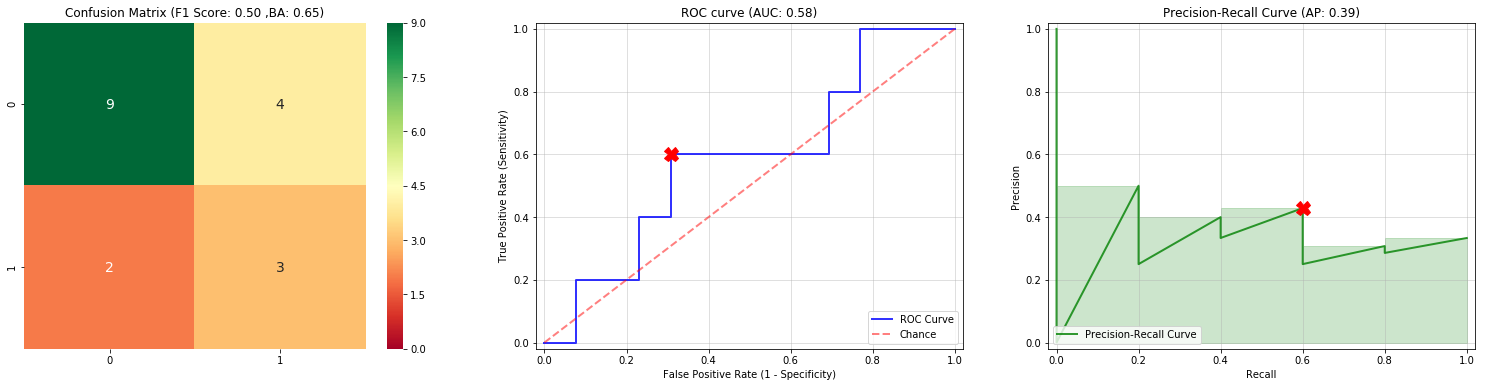

In [18]:
auc_score, average_precision, balanced_accuracy, F1_score = collect_and_print_results(results['SVM_16'])

index_name = 'SVM_TUGs_500_16'
if index_name not in df_results.index or (auc_score + F1_score)/2 > (df_results.loc[index_name, 'AUC_Score'] + df_results.loc[index_name, 'F1_Score'])/2:
    df_results.loc[index_name, :] = ['TUGs', 'SVM', '500', '16', auc_score, F1_score, average_precision, balanced_accuracy]
    plt.savefig(index_name + '.png', bbox_inches='tight')
    df_results.to_pickle("../results.pkl")
    print('---  Results saved!  ---')

### GradientBoosting Classifier on 64 Components PCA

              precision    recall  f1-score   support

 Non Fallers       0.86      0.46      0.60        13
     Fallers       0.36      0.80      0.50         5

   micro avg       0.56      0.56      0.56        18
   macro avg       0.61      0.63      0.55        18
weighted avg       0.72      0.56      0.57        18

ROC Area Under Curve: 0.51
Average Precision:    0.44
Balanced Accuracy:    0.63
F1 Score:             0.5
---  Results saved!  ---


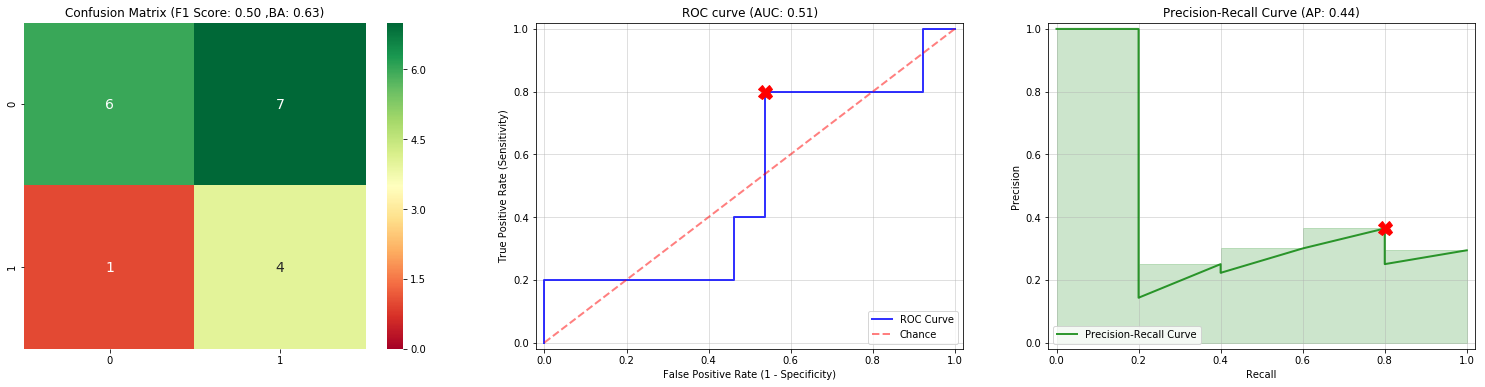

In [19]:
auc_score, average_precision, balanced_accuracy, F1_score = collect_and_print_results(results['GradientBoosting_64'])

index_name = 'GradBoosting_TUGs_500_64'
if index_name not in df_results.index or (auc_score + F1_score)/2 > (df_results.loc[index_name, 'AUC_Score'] + df_results.loc[index_name, 'F1_Score'])/2:
    df_results.loc[index_name, :] = ['TUGs', 'GradientBoosting', '500', '64', auc_score, F1_score, average_precision, balanced_accuracy]
    plt.savefig(index_name + '.png', bbox_inches='tight')
    df_results.to_pickle("../results.pkl")
    print('---  Results saved!  ---')

### GradientBoosting Classifier on 32 Components PCA

              precision    recall  f1-score   support

 Non Fallers       0.89      0.62      0.73        13
     Fallers       0.44      0.80      0.57         5

   micro avg       0.67      0.67      0.67        18
   macro avg       0.67      0.71      0.65        18
weighted avg       0.77      0.67      0.68        18

ROC Area Under Curve: 0.63
Average Precision:    0.4
Balanced Accuracy:    0.71
F1 Score:             0.57
---  Results saved!  ---


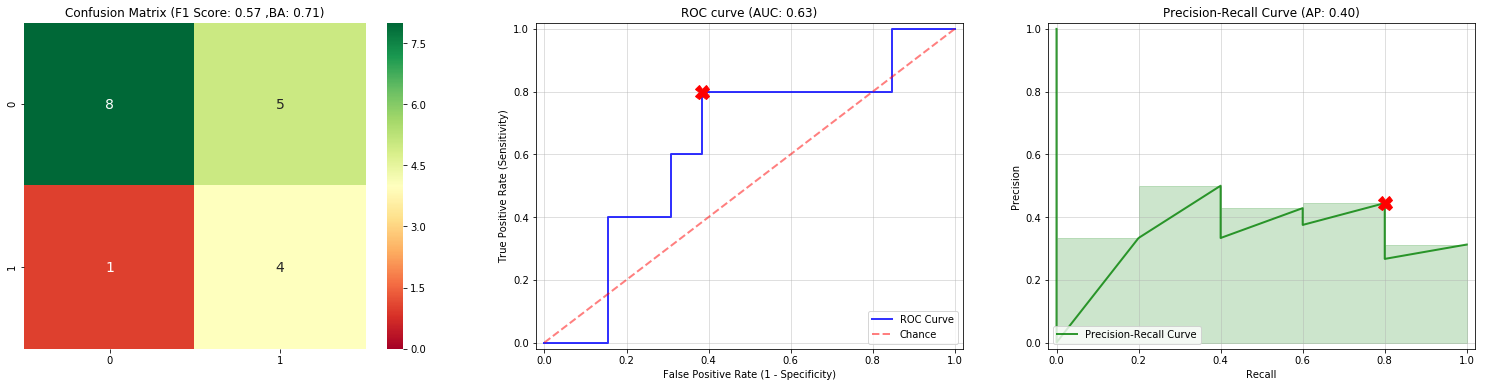

In [20]:
auc_score, average_precision, balanced_accuracy, F1_score = collect_and_print_results(results['GradientBoosting_32'])

index_name = 'GradBoosting_TUGs_500_32'
if index_name not in df_results.index or (auc_score + F1_score)/2 > (df_results.loc[index_name, 'AUC_Score'] + df_results.loc[index_name, 'F1_Score'])/2:
    df_results.loc[index_name, :] = ['TUGs', 'GradientBoosting', '500', '32', auc_score, F1_score, average_precision, balanced_accuracy]
    plt.savefig(index_name + '.png', bbox_inches='tight')
    df_results.to_pickle("../results.pkl")
    print('---  Results saved!  ---')

### GradientBoosting Classifier on 16 Components PCA

              precision    recall  f1-score   support

 Non Fallers       0.80      0.92      0.86        13
     Fallers       0.67      0.40      0.50         5

   micro avg       0.78      0.78      0.78        18
   macro avg       0.73      0.66      0.68        18
weighted avg       0.76      0.78      0.76        18

ROC Area Under Curve: 0.6
Average Precision:    0.44
Balanced Accuracy:    0.66
F1 Score:             0.5
---  Results saved!  ---


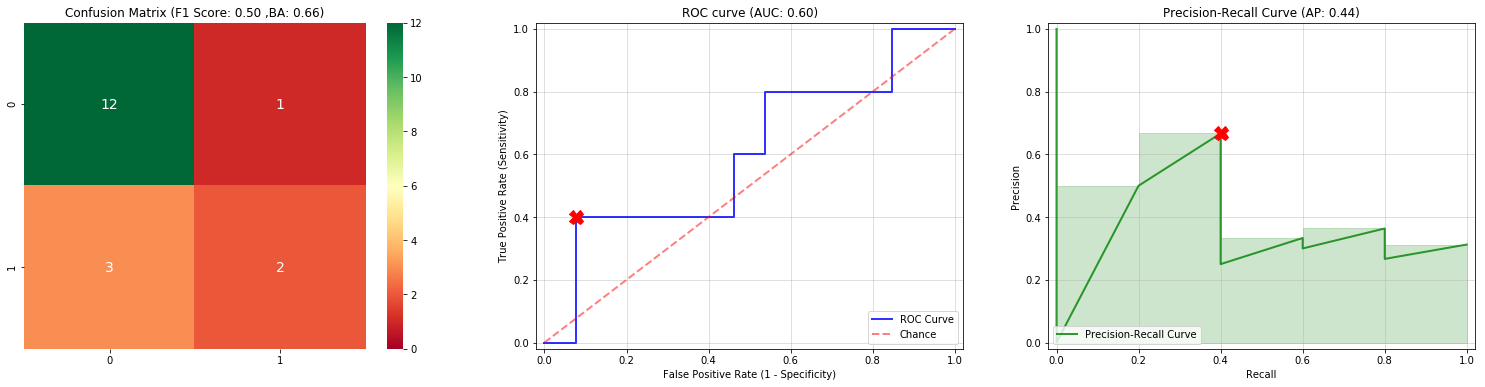

In [21]:
auc_score, average_precision, balanced_accuracy, F1_score = collect_and_print_results(results['GradientBoosting_16'])

index_name = 'GradBoosting_TUGs_500_16'
if index_name not in df_results.index or (auc_score + F1_score)/2 > (df_results.loc[index_name, 'AUC_Score'] + df_results.loc[index_name, 'F1_Score'])/2:
    df_results.loc[index_name, :] = ['TUGs', 'GradientBoosting', '500', '16', auc_score, F1_score, average_precision, balanced_accuracy]
    plt.savefig(index_name + '.png', bbox_inches='tight')
    df_results.to_pickle("../results.pkl")
    print('---  Results saved!  ---')

### AdaBoosting Classifier on 64 Components PCA

              precision    recall  f1-score   support

 Non Fallers       0.88      0.54      0.67        13
     Fallers       0.40      0.80      0.53         5

   micro avg       0.61      0.61      0.61        18
   macro avg       0.64      0.67      0.60        18
weighted avg       0.74      0.61      0.63        18

ROC Area Under Curve: 0.52
Average Precision:    0.33
Balanced Accuracy:    0.67
F1 Score:             0.53
---  Results saved!  ---


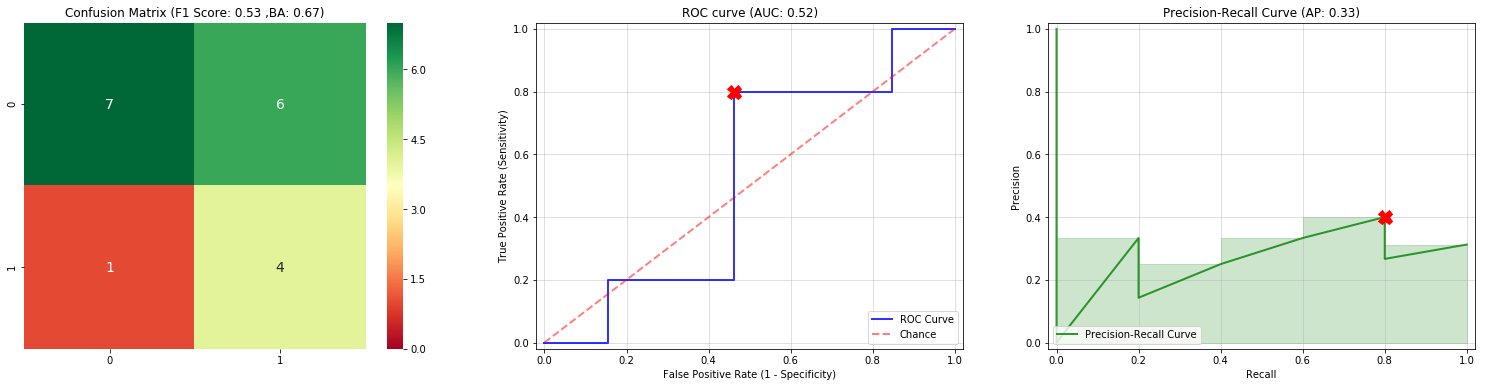

In [22]:
auc_score, average_precision, balanced_accuracy, F1_score = collect_and_print_results(results['AdaBoosting_64'])

index_name = 'AdaBoosting_TUGs_500_64'
if index_name not in df_results.index or (auc_score + F1_score)/2 > (df_results.loc[index_name, 'AUC_Score'] + df_results.loc[index_name, 'F1_Score'])/2:
    df_results.loc[index_name, :] = ['TUGs', 'AdaBoosting', '500', '64', auc_score, F1_score, average_precision, balanced_accuracy]
    plt.savefig(index_name + '.png', bbox_inches='tight')
    df_results.to_pickle("../results.pkl")
    print('---  Results saved!  ---')

### AdaBoosting Classifier on 32 Components PCA

              precision    recall  f1-score   support

 Non Fallers       0.82      0.69      0.75        13
     Fallers       0.43      0.60      0.50         5

   micro avg       0.67      0.67      0.67        18
   macro avg       0.62      0.65      0.62        18
weighted avg       0.71      0.67      0.68        18

ROC Area Under Curve: 0.55
Average Precision:    0.34
Balanced Accuracy:    0.65
F1 Score:             0.5
---  Results saved!  ---


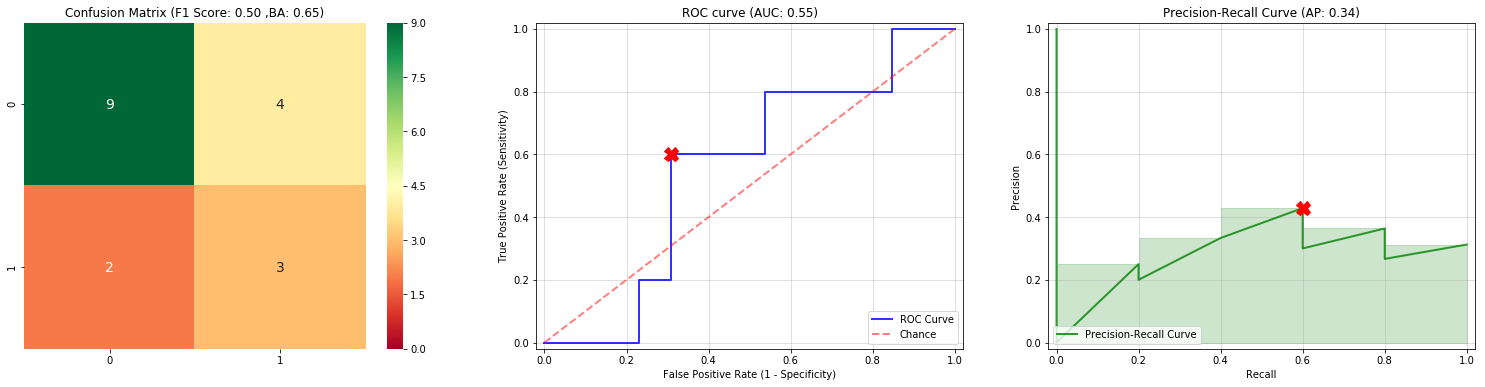

In [23]:
auc_score, average_precision, balanced_accuracy, F1_score = collect_and_print_results(results['AdaBoosting_32'])

index_name = 'AdaBoosting_TUGs_500_32'
if index_name not in df_results.index or (auc_score + F1_score)/2 > (df_results.loc[index_name, 'AUC_Score'] + df_results.loc[index_name, 'F1_Score'])/2:
    df_results.loc[index_name, :] = ['TUGs', 'AdaBoosting', '500', '32', auc_score, F1_score, average_precision, balanced_accuracy]
    plt.savefig(index_name + '.png', bbox_inches='tight')
    df_results.to_pickle("../results.pkl")
    print('---  Results saved!  ---')

### AdaBoosting Classifier on 16 Components PCA

              precision    recall  f1-score   support

 Non Fallers       0.89      0.62      0.73        13
     Fallers       0.44      0.80      0.57         5

   micro avg       0.67      0.67      0.67        18
   macro avg       0.67      0.71      0.65        18
weighted avg       0.77      0.67      0.68        18

ROC Area Under Curve: 0.62
Average Precision:    0.39
Balanced Accuracy:    0.71
F1 Score:             0.57
---  Results saved!  ---


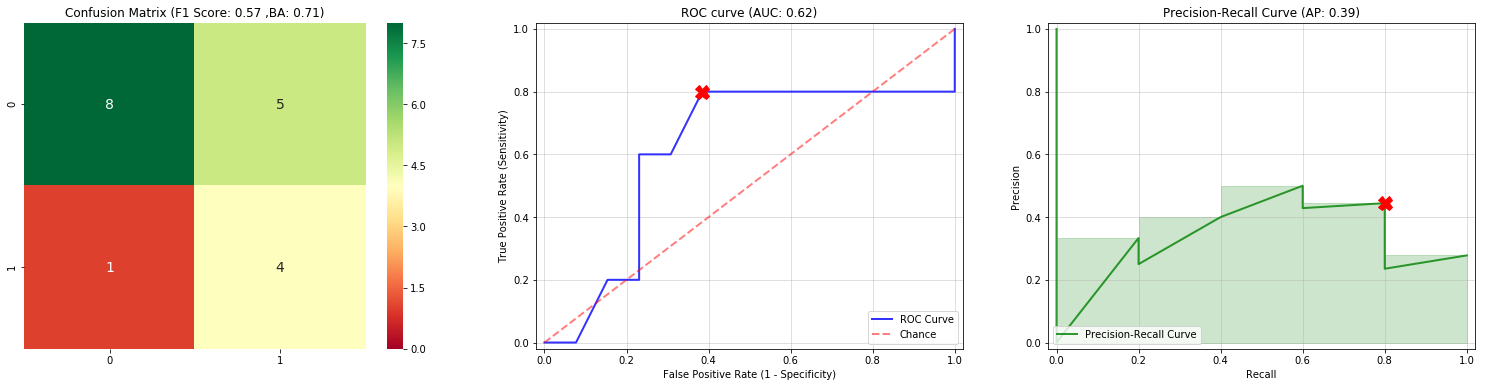

In [24]:
auc_score, average_precision, balanced_accuracy, F1_score = collect_and_print_results(results['AdaBoosting_16'])

index_name = 'AdaBoosting_TUGs_500_16'
if index_name not in df_results.index or (auc_score + F1_score)/2 > (df_results.loc[index_name, 'AUC_Score'] + df_results.loc[index_name, 'F1_Score'])/2:
    df_results.loc[index_name, :] = ['TUGs', 'AdaBoosting', '500', '16', auc_score, F1_score, average_precision, balanced_accuracy]
    plt.savefig(index_name + '.png', bbox_inches='tight')
    df_results.to_pickle("../results.pkl")
    print('---  Results saved!  ---')